In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [2]:
df = pd.read_csv('../data/heloc_dataset_v1.csv')

In [3]:
df = df[df.columns[:5]] #just test on the first 5 columns

In [4]:
df_feat = df.copy()

In [5]:
df_feat['RiskPerformance'] = df_feat.RiskPerformance.astype('category').cat.codes # bad -> 0, good -> 1

In [6]:
from sklearn.preprocessing import normalize

In [7]:
def discretize_features(df, cols, n_buckets=5, norm='max'):
    # create n_buckets distinct values for each column
    # todo: update the bucketing strategy to follow the CDF instead of a fixed range
    for col_name in cols:
        col = df[col_name]
        bucket_size = int((max(col) - min(col))/n_buckets)
        df[col_name] = col.apply(lambda val: int(val/bucket_size))
    #normalize along the features
    normalized_features = normalize(df.values, norm=norm, axis=0).T
    for col_name, norm_feat in zip(df.columns, normalized_features): 
        df[col_name] = norm_feat

In [8]:
label_col = df_feat.columns[0]
attribute_cols = df_feat.columns[1:]

In [9]:
discretize_features(df_feat, attribute_cols) # output column is already normalized.

In [10]:
from collections import defaultdict

keep the mapping of the transformed features into the original data ranges

In [11]:
def feature_range_map(df, df_feat, cols):
    col_bucket_range_map = {}
    for col in cols:
        orig_col = df[col]
        feat_col = df_feat[col]
        feat_col_values = defaultdict(list)
        for feat_val, orig_val in zip(feat_col, orig_col):
            feat_col_values[feat_val].append(orig_val)
        feat_col_values = {feat_val: (min(orig_vals), max(orig_vals)) for feat_val, orig_vals in feat_col_values.items()}
        col_bucket_range_map[col] = feat_col_values
    return col_bucket_range_map

In [12]:
col_bucket_range_map = feature_range_map(df, df_feat, attribute_cols)

In [13]:
y = df_feat.RiskPerformance.values

In [14]:
X = df_feat.drop('RiskPerformance', axis=1).values

In [15]:
np.random.seed(1234)
shuffle_idx = np.random.permutation(len(y))

In [16]:
y = y[shuffle_idx]

In [17]:
X = X[shuffle_idx]

train our model

In [18]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

In [20]:
def train_svm(X, y):
    svm = SVC(probability=True)
    svm.fit(X, y)
    return svm

train the global black box model on the original data

In [135]:
svm = train_svm(X, y)

/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [136]:
type(svm) is SVC

True

In [21]:
lr = LogisticRegression(n_jobs=-1)
lr.fit(X, y)

/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 48.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
def error(model, X, y):
    y_pred = model.predict_proba(X)
    class_idx = np.argwhere(model.classes_ == 1)[0]
    class_prob = y_pred[:, class_idx] # get the probabilities of the class label 1
    error = 1 - roc_auc_score(y, class_prob)
    return error

randomly shuffle X beforehand, incase there is a pattern

In [169]:
def df_to_features(df, attribute_cols, label_col):
    return df[attribute_cols].values, df[label_col].values

In [170]:
def feature_importance(model, df, attribute_cols, label_col):
    feature_importances = []
    X, y = df_to_features(df, attribute_cols, label_col)
    global_error = error(model, X, y)
    for col in range(len(X[0])):
        X_perm = X.copy()
        X_perm[: , col] = X_perm[np.random.permutation(len(X)), col]
        #X_perm[: , col] = X_perm[: , col][::-1] #permute the columns by reversing the order
        
        feature_error = error(model, X_perm, y)
        feature_importance = feature_error/global_error
        
        feature_importances.append(feature_importance)
    return np.array(feature_importances) / np.sum(feature_importances)

In [23]:
def class_func_exists(cls, func):
    return callable(getattr(cls, func, None))

In [24]:
class ModelInterpretation:
    def __init__(self, model, label_col, attribute_cols):
        if not class_func_exists(model, 'predict_proba'):
            raise RuntimeError(f'Model {type(model)} does not have required predict_proba function needed to calculate AUC')
        self.model = model
        self.label_col = label_col
        self.attribute_cols = attribute_cols
        
    def context_to_features(self, context):
        return context.df[self.attribute_cols].values, context.df[self.label_col].values
        
    def on(self, context):
        if class_func_exists(self, 'get_weights_decomp'):
            return self.get_weights_decomp(context)
        else:
            return self.get_weights(context)
        
    def get_weights(self, context):
        raise NotImplementedError

In [25]:
class FeatureImportance(ModelInterpretation):
    def __init__(self, model, label_col, attribute_cols):
        super(FeatureImportance, self).__init__(model, label_col, attribute_cols)
        
    def error(self, X, y):
        y_pred = self.model.predict_proba(X)
        class_idx = np.argwhere(self.model.classes_ == 1)[0]
        class_prob = y_pred[:, class_idx] # get the probabilities of the class label 1
        error = 1 - roc_auc_score(y, class_prob)
        return error
    
    def get_weights(self, context):
        feature_importances = []
        X, y = self.context_to_features(context)
        global_error = self.error(X, y)
        
        # destroy each feature by shuffling and record the magnitude increase in error
        for col in range(len(X[0])):
            X_perm = X.copy()
            X_perm[: , col] = X_perm[np.random.permutation(len(X)), col]
            feature_error = self.error(X_perm, y)
            feature_importance = feature_error/global_error
            feature_importances.append(feature_importance)
        
        # give normalized feature weights
        return np.array(feature_importances) / np.sum(feature_importances)

### Lattice Based Approach

In [ ]:
# Set up a more generic interpretability function definition, which supports both 
# batch and decomposable(cached) feature importance calculations.

In [47]:
from operator import and_
from functools import reduce
from copy import copy

# predicates in the form {'q': 1, 'v': 2, ...}
class Context:
    def __init__(self, predicates, df):
        self.predicates = predicates
        self.df = df
        
    def conflicts(self, context):
        other_predicates = context.predicates
        for key, value in self.predicates.items():
            if key in other_predicates and other_predicates[key] != value:
                return True
        return False
            
    def get_context_df(self):
        if len(self.predicates) == 0:
            return self.df
        
        # find rows in the df where the conjunction of predicates hold
        df_predicates = [df_feat[col_name] == col_value for col_name, col_value 
                         in self.predicates.items()]
        row_mask = reduce(and_, df_predicates)
        return self.df[row_mask]
    
    def __len__(self):
        return len(self.df)
    
    def __str__(self):
        return ' ^ '.join([f'{key} = {value}' for key, value in self.predicates.items()])
    
    def __repr__(self):
        return self.__str__()
    
#create a new context with additional predicates
def extend_predicates(context, new_predicates):
    # avoid using deepcopy to prevent redundant df copies, only predicates are updated
    new_context = Context(context.predicates.copy(), context.df)
    new_context.predicates.update(new_predicates)
    return new_context
    

In [58]:
class LatticeCMI:
    def __init__(self, df_feat, model_interpration, context_set_size=20, min_context_size=100, min_similarity=0.01, beam_width=100):
        self.df_feat = df_feat
        self.model_interpration = model_interpration
        
        self.return_set = set()
        self.candidate_set = defaultdict(list) #need to keep track of the different levels of predicates

        self.context_set_size = context_set_size
        self.min_context_size = min_context_size
        self.min_similarity = min_similarity
        self.max_conjunction_size = max_conjunction_size
        self.beam_width = beam_width
        
        self.level = 0
        
    def sort_subcontext(self, subcontext, glob_mi):
        # based on the model importance delta and size, bucket the subcontext accordingly
        # remember that large valid contexts are returned and removed from futher splits
        contextual_mi = self.model_interpration.on(subcontext)
        delta = np.linalg.norm(glob_mi - contextual_mi, ord=1)

        if delta > self.min_similarity and len(subcontext) > self.min_context_size:
            self.return_set.add(subcontext)
        else:
            self.candidate_set[self.level].append((delta, subcontext))
            
    def inital_candidate_set(self, global_context, glob_mi):
        # Calculate first level predicates and add them to candidate set
        for col_name in self.model_interpration.attribute_cols:
            for feat_value in self.df_feat[col_name].unique():
                subcontext = extend_predicates(global_context, {col_name: feat_value})
                self.sort_subcontext(subcontext, glob_mi)

        # build in order of the predicates with the highest delta, maintain a beam width param
        self.candidate_set[self.level] = sorted(self.candidate_set[self.level], reverse=True)
    
    def check_all_conditions(self):
        ret_set_len = len(self.return_set) < self.context_set_size
        cand_set = len(self.candidate_set[self.level-1]) > 0
        conj_size = self.level <= self.max_conjunction_size
        return ret_set_len and cand_set and conj_size
    
    def generate_lattice(self, glob_mi):
        while self.check_all_conditions():
            # build predicates from level 1 and level-1 and store in current level
            for _, prev_context in self.candidate_set[self.level-1][:self.beam_width]:
                for _, base_context in self.candidate_set[1][:self.beam_width]:

                    # check if the combined predicates do no contradict each other, ie combining q=q1^z=z2 and q=q2
                    # note that overlap is ok q=q2^z=z2 and q=q2, thus the width of the predicate is <= level
                    if base_context.conflicts(prev_context):
                        continue

                    subcontext = extend_predicates(prev_context, base_context.predicates)
                    # if delta is still not high enough and the size dips below min_context_size, remove that context
                    if len(subcontext) < min_context_size:
                        continue

                    self.sort_subcontext(subcontext, glob_mi)
                    
            self.candidate_set[level] = sorted(self.candidate_set[self.level], reverse=True)
            self.level += 1
        
    def generate_return_set(self):
        self.level = 0
        global_context = Context({}, self.df_feat)
        self.candidate_set[self.level].append(global_context)
        glob_mi = self.model_interpration.on(global_context)
        
        self.level += 1
        self.inital_candidate_set(global_context, glob_mi)
        
        self.level += 1
        self.generate_lattice(glob_mi)
        
        return self.return_set

In [67]:
feature_importance = FeatureImportance(lr, label_col, attribute_cols)
cmi = LatticeCMI(df_feat, feature_importance, min_similarity=0.02)

In [68]:
contexts = cmi.generate_return_set()

In [69]:
len(contexts)

1

In [71]:
contexts

{MSinceOldestTradeOpen = 0.75 ^ MSinceMostRecentTradeOpen = 1.0 ^ AverageMInFile = 0.0}

In [78]:
cmi.candidate_set[4]

[(0.005205330557709192,
  AverageMInFile = 0.75 ^ MSinceOldestTradeOpen = 1.0 ^ ExternalRiskEstimate = 1.0),
 (0.0019913574952013513,
  AverageMInFile = 0.75 ^ MSinceOldestTradeOpen = 1.0 ^ ExternalRiskEstimate = 0.25),
 (0.00887891512494135,
  AverageMInFile = 0.75 ^ MSinceOldestTradeOpen = 1.0 ^ ExternalRiskEstimate = 0.5),
 (0.0012394288353437533,
  AverageMInFile = 0.75 ^ MSinceOldestTradeOpen = 1.0 ^ MSinceMostRecentTradeOpen = 0.0),
 (0.0034046691797668116,
  AverageMInFile = 0.75 ^ MSinceOldestTradeOpen = 1.0 ^ ExternalRiskEstimate = 0.0),
 (0.004825882049181801, AverageMInFile = 0.75 ^ MSinceOldestTradeOpen = 1.0),
 (0.0021192250363569476,
  AverageMInFile = 0.75 ^ MSinceOldestTradeOpen = 1.0 ^ ExternalRiskEstimate = 0.75),
 (0.0046839885182373975, AverageMInFile = 0.75 ^ MSinceOldestTradeOpen = 1.0),
 (0.003771257963817276,
  AverageMInFile = 0.75 ^ MSinceOldestTradeOpen = 1.0 ^ MSinceMostRecentTradeOpen = 0.25),
 (0.003371621939935232,
  AverageMInFile = 0.75 ^ MSinceOldestTr

In [70]:
cmi.candidate_set

defaultdict(list,
            {0: [],
             1: [(0.0094305172785826, ExternalRiskEstimate = 1.0),
              (0.009375565669463848, AverageMInFile = 1.0),
              (0.008555310347490741, ExternalRiskEstimate = 0.25),
              (0.007592309665911429, ExternalRiskEstimate = 0.5),
              (0.007120908193961467, MSinceOldestTradeOpen = 0.75),
              (0.006599194158063482, AverageMInFile = 0.0),
              (0.005935114266246794, AverageMInFile = 0.5),
              (0.005665302766199393, MSinceMostRecentTradeOpen = 0.0),
              (0.005615544649793136, MSinceOldestTradeOpen = 0.0),
              (0.005561193983829704, ExternalRiskEstimate = 0.0),
              (0.00533060567520266, AverageMInFile = 0.75),
              (0.005299578475899125, ExternalRiskEstimate = 0.75),
              (0.005281798353602679, MSinceOldestTradeOpen = 1.0),
              (0.005158728799105866, AverageMInFile = 0.25),
              (0.0045578501646722225, MSinceOldestTrade

In [65]:
len(contexts)

0

In [48]:
return_set = set()
candidate_set = defaultdict(list) #need to keep track of the different levels of predicates
candidate_set[0].append(Context({}, df_feat)) 

context_set_size = 20
min_context_size = 100
min_similarity = 0.01
max_conjunction_size = 5
beam_width = 100

In [49]:
level = 1
global_context = Context({}, df_feat)
feature_importance = FeatureImportance(lr, label_col, attribute_cols)

In [51]:
glob_fi = feature_importance.on(global_context)

In [52]:
# Calculate first level predicates and add them to candidate set
for col_name in attribute_cols:
    for feat_value in df_feat[col_name].unique():
        subcontext = extend_predicates(global_context, {col_name: feat_value})
        
        contextual_fi = feature_importance.on(subcontext)
        delta = np.linalg.norm(glob_fi - contextual_fi, ord=1)
        
        if delta > min_similarity and len(subcontext) > min_context_size:
            return_set.add(subcontext)
        else:
            candidate_set[level].append((delta, subcontext))

            # build in order of the predicates with the highest delta, mainain a beam width param
candidate_set[level] = sorted(candidate_set[level], reverse=True)

In [53]:
level += 1
while len(return_set) < context_set_size and len(candidate_set[level-1]) > 0 and level <= max_conjunction_size:
    # build predicates from level 1 and level-1 and store in current level
    for _, prev_context in candidate_set[level-1][:beam_width]:
        for _, base_context in candidate_set[1][:beam_width]:
            
            # check if the combined predicates do no contradict each other, ie combining q=q1^z=z2 and q=q2
            if base_context.conflicts(prev_context):
                continue
            
            subcontext = extend_predicates(prev_context, base_context.predicates)
            # if delta is still not high enough and the size dips below min_context_size, remove that context
            if len(subcontext.df) < min_context_size:
                continue

            contextual_fi = feature_importance.on(subcontext)
            delta = np.linalg.norm(glob_fi - contextual_fi, ord=1)

            if delta > min_similarity and len(subcontext) > min_context_size:
                return_set.add(subcontext)
            else:
                candidate_set[level].append((delta, subcontext))
        print(len(candidate_set[level]), len(return_set))
    candidate_set[level] = sorted(candidate_set[level], reverse=True)
    level += 1
    print(f'level {level}', len(return_set))

9 7
19 9
28 11
36 14
47 15
58 16
69 16
81 16
92 16
102 18
111 20
120 22
128 26
137 28
level 3 28


In [54]:
return_set

{AverageMInFile = 0.0 ^ MSinceMostRecentTradeOpen = 0.5,
 AverageMInFile = 0.25,
 AverageMInFile = 0.5,
 AverageMInFile = 0.75 ^ ExternalRiskEstimate = 0.0,
 AverageMInFile = 0.75 ^ MSinceMostRecentTradeOpen = 1.0,
 AverageMInFile = 1.0 ^ ExternalRiskEstimate = 0.5,
 AverageMInFile = 1.0 ^ MSinceMostRecentTradeOpen = 0.0,
 AverageMInFile = 1.0 ^ MSinceMostRecentTradeOpen = 0.25,
 AverageMInFile = 1.0 ^ MSinceMostRecentTradeOpen = 1.0,
 ExternalRiskEstimate = 0.25 ^ MSinceMostRecentTradeOpen = 0.5,
 ExternalRiskEstimate = 0.25 ^ MSinceOldestTradeOpen = 0.75,
 ExternalRiskEstimate = 0.5,
 ExternalRiskEstimate = 0.5 ^ MSinceMostRecentTradeOpen = 0.0,
 ExternalRiskEstimate = 0.75,
 ExternalRiskEstimate = 1.0 ^ AverageMInFile = 0.75,
 ExternalRiskEstimate = 1.0 ^ MSinceMostRecentTradeOpen = 0.5,
 MSinceMostRecentTradeOpen = 0.0 ^ AverageMInFile = 0.0,
 MSinceMostRecentTradeOpen = 0.0 ^ MSinceOldestTradeOpen = 0.75,
 MSinceMostRecentTradeOpen = 0.5 ^ ExternalRiskEstimate = 0.0,
 MSinceMostRe

### Tree Based Approach

In [328]:
def data_subsets(df, attribute_cols, label_col, col_name, col_val, eq_to_col_val = True):
    if eq_to_col_val:
        subset = df[col_name == col_val]
        return subset[attribute_cols].values, subset[label_col].values
    else:
        subset = df[col_name != col_val]
        return subset[attribute_cols].values, subset[label_col].values

In [29]:
from treelib import Node, Tree

Store all the paths within the tree

In [149]:
def best_fi_split(model, X, y, prev_fi, context_size_booster):
    
    if prev_fi is None:
        prev_fi = feature_importance(model, X, y)
    best_fi = None
    best_fi_delta = 0
    best_fi_delta_unnorm = 0
    best_col_split = None
    best_col_val_split = None
    
    for col_num in range(1, X.shape[1]):
        for col_val in set(X[:, col_num]):
            # at this level we are interested to see if the explanations for this context differs from
            # the previous parent context. We can leave the context column in as it is non-informative
            X_sub, y_sub = data_subsets(X, y, col_num, col_val)
            
            # don't run svm on data with 1 class
            if len(set(y_sub)) == 1:
                continue
                
            contextual_fi = feature_importance(model, X_sub, y_sub)
            
            # delta will be computed by the L2 norm plus a size regulaizer. We observe that without this 
            # size penalty, the procedure will usually return a very small context that deviates from
            # the previous (large) parent context, thus we have a term to control this behavior. 
            # fi_delta = np.linalg.norm(prev_fi - contextual_fi) + context_size_reg * np.log(len(y_sub))
            fi_delta = np.linalg.norm(prev_fi - contextual_fi, ord=1) * np.log(len(y_sub))**context_size_booster
            if fi_delta > best_fi_delta:
                best_fi = contextual_fi
                best_fi_delta = fi_delta
                best_fi_delta_unnorm = np.linalg.norm(prev_fi - contextual_fi, ord=1)
                best_col_split = col_num
                best_col_val_split = col_val
#         print(f"col num {col_num}")
                
    
    return best_fi, best_fi_delta, best_fi_delta_unnorm, best_col_split, best_col_val_split

In [153]:
def compute_contexts(model, X, y, prev_fi, parent, threshold=1e-3, max_depth=5, max_nodes=75, context_size_booster=1.0):
    if tree.depth(node = parent) == max_depth or len(tree) > max_nodes or len(set(y)) <= 1:
        return
                
    best_fi, best_fi_delta, best_fi_delta_unnorm, best_col_split, best_col_val_split = best_fi_split(model, X, y, prev_fi, context_size_booster)
            
    if best_fi_delta < threshold: # a further context split will not be informative, stop here
        return
    
    X_sub, y_sub = data_subsets(X, y, best_col_split, best_col_val_split)
    X_sub_inv, y_sub_inv = data_subsets(X, y, best_col_split, best_col_val_split, eq_to_col_val=False)  
    
    best_col_name = bdf.columns[best_col_split]
    print(best_col_name, best_col_val_split)
    best_split_node_name = f"{best_col_name}: {col_bucket_range_map[best_col_name][best_col_val_split]}, dist={pd.Series(y_sub).value_counts().to_dict()}"
    print(f"split at {best_split_node_name}")
    other_split_node_name = f"others, dist={pd.Series(y_sub_inv).value_counts().to_dict()}"

    split_node = tree.create_node(best_split_node_name, parent=parent)
    other_node = tree.create_node(other_split_node_name, parent=parent)
    
    compute_contexts(model, X_sub, y_sub, best_fi, split_node.identifier)
    
    # for the data not in the most distinctive context, find the next best context and so on  
    compute_contexts(model, X_sub_inv, y_sub_inv, prev_fi, other_node.identifier)

In [154]:
bdf = df_feat

In [155]:
tree = Tree()
tree.create_node("Global", "global")
compute_contexts(lr, X, y, None, "global", context_size_booster=3)

/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in

NumInstallTradesWBalance -0.3333333333333333
split at NumInstallTradesWBalance: (-9, -8), dist={0.0: 746, 1.0: 425}


/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in 

/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in

AverageMInFile 0.5
split at AverageMInFile: (156, 233), dist={1.0: 3, 0.0: 2}


/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in 

/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in 

NumTotalTrades 0.0
split at NumTotalTrades: (-9, 21), dist={0.0: 2, 1.0: 2}


/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in 

ExternalRiskEstimate 0.25
split at ExternalRiskEstimate: (33, 39), dist={1.0: 2, 0.0: 1}


/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in 

NumTradesOpeninLast12M 0.5


/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/localscratch/ksamel3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in 

KeyError: 0.5

In [157]:
col_bucket_range_map['NumTradesOpeninLast12M']

{0.0: (0, 4),
 0.3333333333333333: (5, 9),
 -0.3333333333333333: (-9, -9),
 0.6666666666666666: (10, 14),
 1.0: (16, 19)}

With increased context_size_booster, we see that the size of the contexts increase as well. This is a perference that we have to set. Do we want to look at:
* Larger more general groups that we can analyze, context_size_booster > 1
* Small groups that do have different explanations that are typically overlooked, context_size_booster <= 1

N=500

In [413]:
tree.show()

Global
├── ExternalRiskEstimate: [60, 79], dist={1: 163, 0: 123}
│   ├── NumRevolvingTradesWBalance: [8, 15], dist={0: 17, 1: 15}
│   │   ├── NumBank2NatlTradesWHighUtilization: [0, 4], dist={1: 13, 0: 12}
│   │   │   ├── ExternalRiskEstimate: [60, 79], dist={1: 13, 0: 12}
│   │   │   │   ├── AverageMInFile: [78, 155], dist={1: 6, 0: 3}
│   │   │   │   └── others, dist={0: 9, 1: 7}
│   │   │   └── others, dist={}
│   │   └── others, dist={0: 5, 1: 2}
│   │       ├── ExternalRiskEstimate: [60, 79], dist={0: 5, 1: 2}
│   │       │   ├── NumBank2NatlTradesWHighUtilization: [5, 9], dist={0: 5, 1: 2}
│   │       │   └── others, dist={}
│   │       └── others, dist={}
│   └── others, dist={1: 148, 0: 106}
│       ├── PercentTradesNeverDelq: [63, 83], dist={0: 18, 1: 15}
│       │   ├── NumTotalTrades: [-9, 21], dist={0: 15, 1: 8}
│       │   │   ├── MSinceMostRecentInqexcl7days: [0, 5], dist={0: 8, 1: 7}
│       │   │   └── others, dist={0: 7, 1: 1}
│       │   └── others, dist={1: 7, 0: 3}


In [402]:
tree.show()

Global
├── MSinceMostRecentDelq: [18, 35], dist={1: 26, 0: 22}
│   ├── MSinceMostRecentInqexcl7days: [0, 5], dist={1: 18, 0: 11}
│   │   ├── PercentInstallTrades: [21, 41], dist={1: 11, 0: 4}
│   │   │   ├── NumTrades90Ever2DerogPubRec: [0, 4], dist={1: 11, 0: 4}
│   │   │   │   ├── NetFractionRevolvingBurden: [-9, 47], dist={1: 8, 0: 3}
│   │   │   │   └── others, dist={1: 3, 0: 1}
│   │   │   └── others, dist={}
│   │   └── others, dist={1: 7, 0: 7}
│   │       ├── MSinceMostRecentDelq: [18, 35], dist={1: 7, 0: 7}
│   │       │   ├── NumInstallTradesWBalance: [1, 5], dist={0: 7, 1: 4}
│   │       │   └── others, dist={1: 3}
│   │       └── others, dist={}
│   └── others, dist={0: 11, 1: 8}
│       ├── MSinceMostRecentDelq: [18, 35], dist={0: 11, 1: 8}
│       │   ├── PercentTradesNeverDelq: [84, 100], dist={0: 10, 1: 6}
│       │   │   ├── NumRevolvingTradesWBalance: [0, 7], dist={0: 8, 1: 6}
│       │   │   └── others, dist={0: 2}
│       │   └── others, dist={1: 2, 0: 1}
│       │ 

In [400]:
tree.show()

Global
├── PercentInstallTrades: [63, 83], dist={0: 15, 1: 12}
│   ├── NetFractionInstallBurden: [-9, 95], dist={0: 15, 1: 10}
│   │   ├── NumTrades60Ever2DerogPubRec: [0, 4], dist={0: 13, 1: 10}
│   │   │   ├── NumInstallTradesWBalance: [1, 5], dist={0: 13, 1: 9}
│   │   │   │   ├── NumBank2NatlTradesWHighUtilization: [0, 4], dist={0: 10, 1: 9}
│   │   │   │   └── others, dist={0: 3}
│   │   │   └── others, dist={1: 1}
│   │   └── others, dist={0: 2}
│   └── others, dist={1: 2}
└── others, dist={1: 314, 0: 159}
    ├── MaxDelqEver: [2, 2], dist={0: 12, 1: 10}
    │   ├── MSinceMostRecentTradeOpen: [-9, 77], dist={0: 12, 1: 10}
    │   │   ├── PercentTradesWBalance: [84, 100], dist={0: 5, 1: 2}
    │   │   │   ├── ExternalRiskEstimate: [60, 79], dist={1: 2, 0: 2}
    │   │   │   └── others, dist={0: 3}
    │   │   └── others, dist={1: 8, 0: 7}
    │   │       ├── NumInstallTradesWBalance: [1, 5], dist={1: 6, 0: 6}
    │   │       └── others, dist={1: 2, 0: 1}
    │   └── others, dist={

### View the FI delta with respect to the contex size booster

In [179]:
ci_deltas = []
ci_sizes = []
test_ci_boosters = np.arange(0, 10, 0.2)
for context_size_booster in test_ci_boosters:
    best_fi, best_fi_delta, best_fi_delta_unnorm, best_col_split, best_col_val_split = best_fi_split(lr, X, y, None, context_size_booster)
    X_sub, y_sub = data_subsets(X, y, best_col_split, best_col_val_split)
    ci_deltas.append(best_fi_delta_unnorm)
    ci_sizes.append(len(y_sub))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in double_scalars


In [107]:
plt.rcParams['font.size']

10.0

In [118]:
plt.rcParams['lines.linewidth']

1.5

In [126]:
plt.rcParams.update({'lines.linewidth': 1.5})
plt.rcParams.update({'font.size': 10})

In [151]:
plt.rcParams.update({'lines.linewidth': 5})
plt.rcParams.update({'font.size': 40})

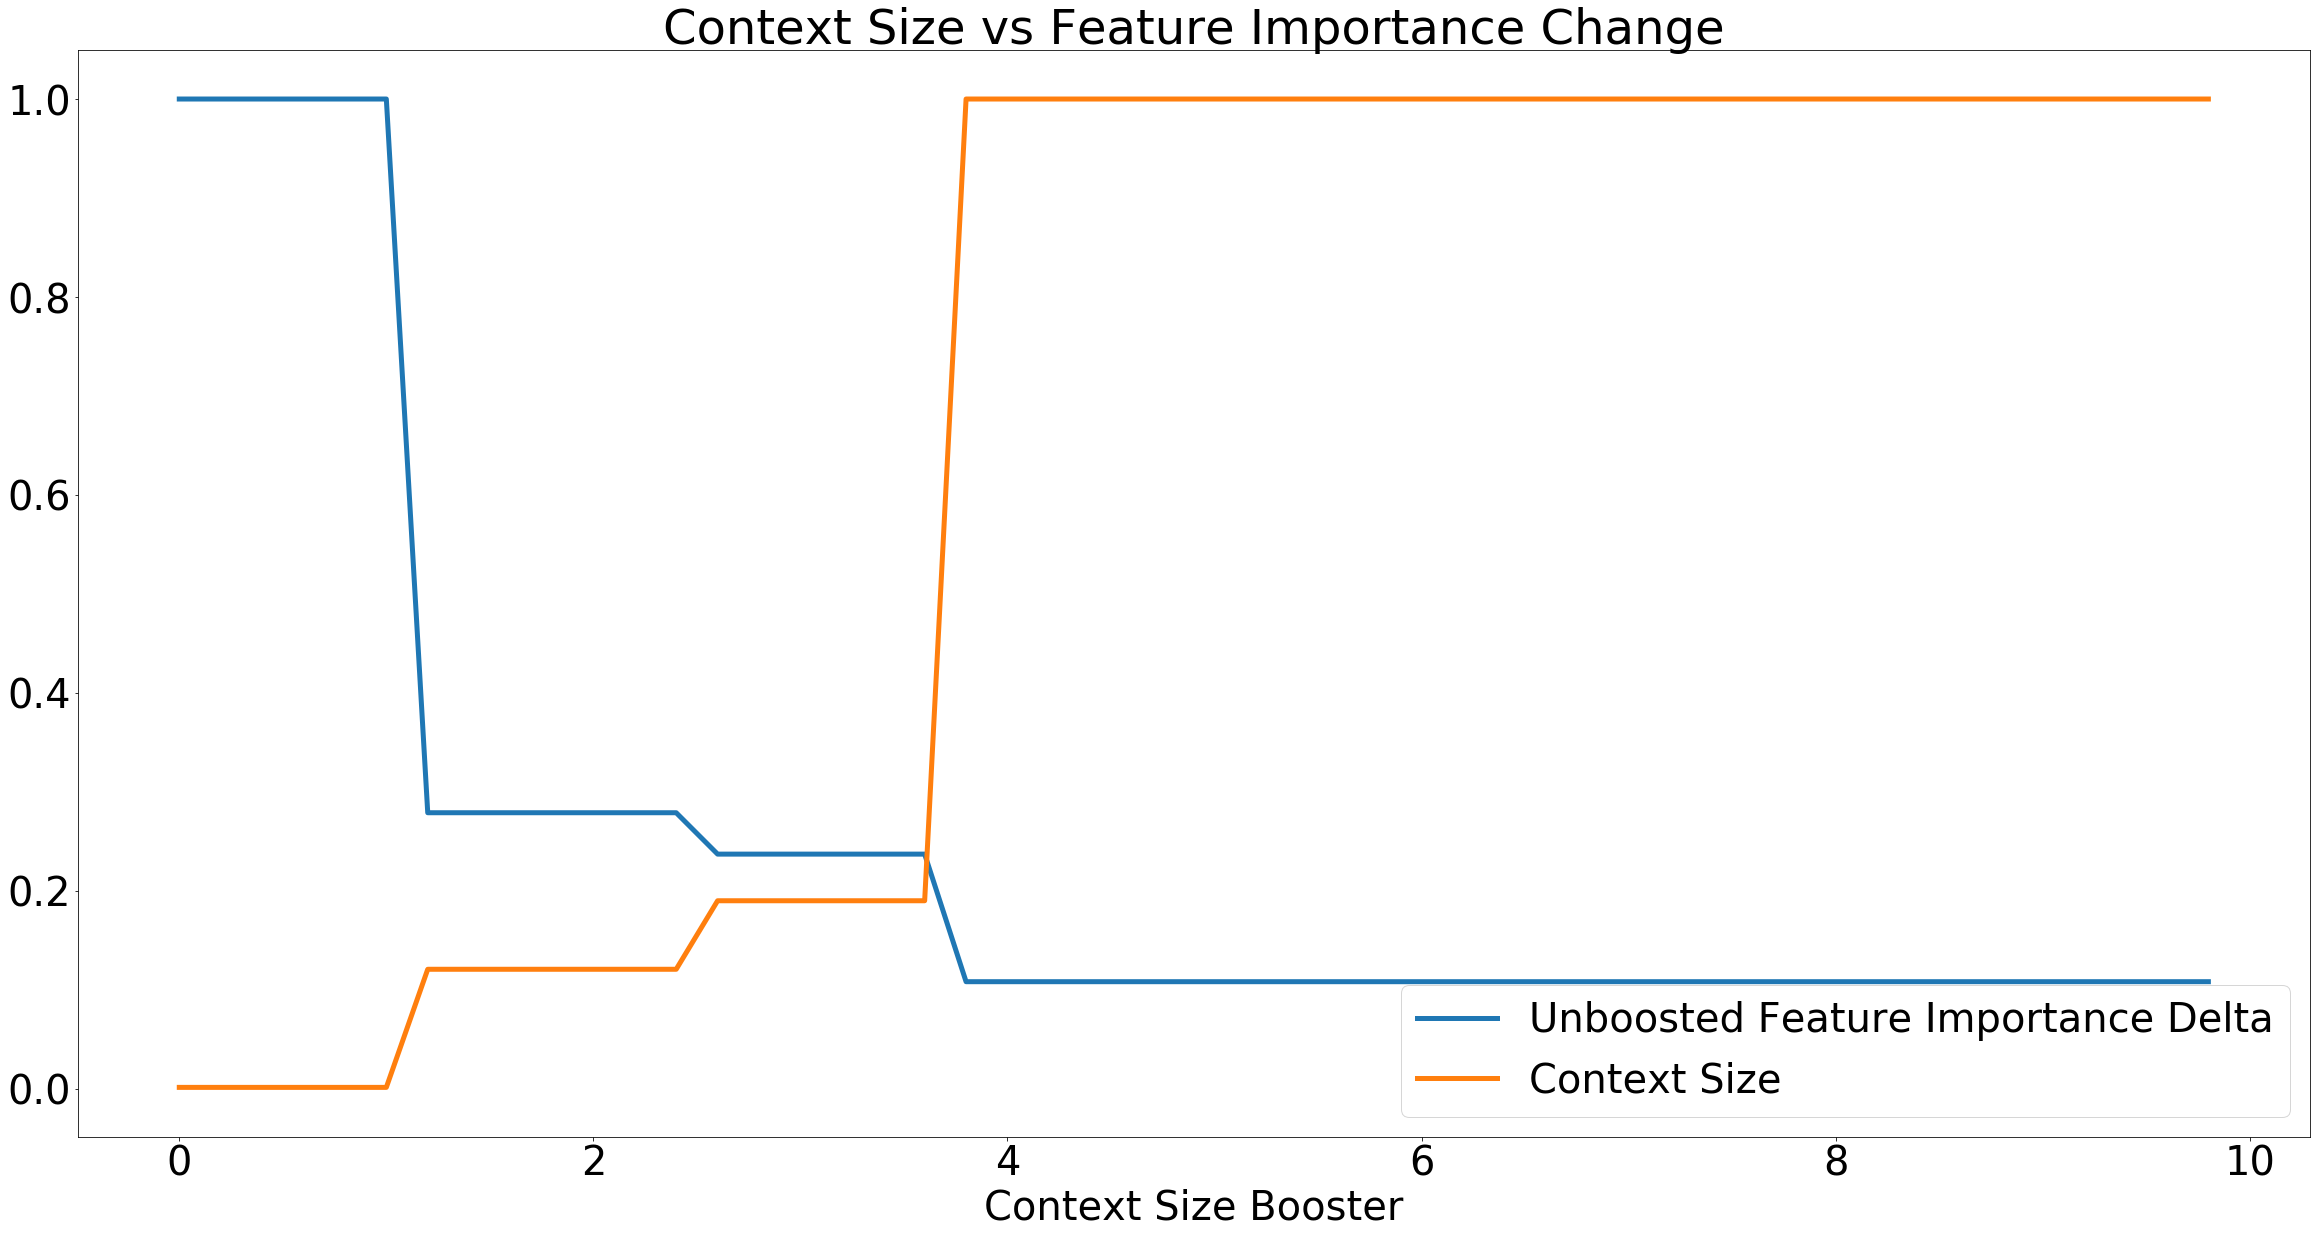

In [180]:
plt.figure(figsize=(40, 20))
plt.plot(test_ci_boosters, np.array(ci_deltas)/np.max(ci_deltas), label='Unboosted Feature Importance Delta')
plt.plot(test_ci_boosters, np.array(ci_sizes)/np.max(ci_sizes), label='Context Size')
plt.title('Context Size vs Feature Importance Change')
plt.xlabel('Context Size Booster')
plt.legend()
plt.show()

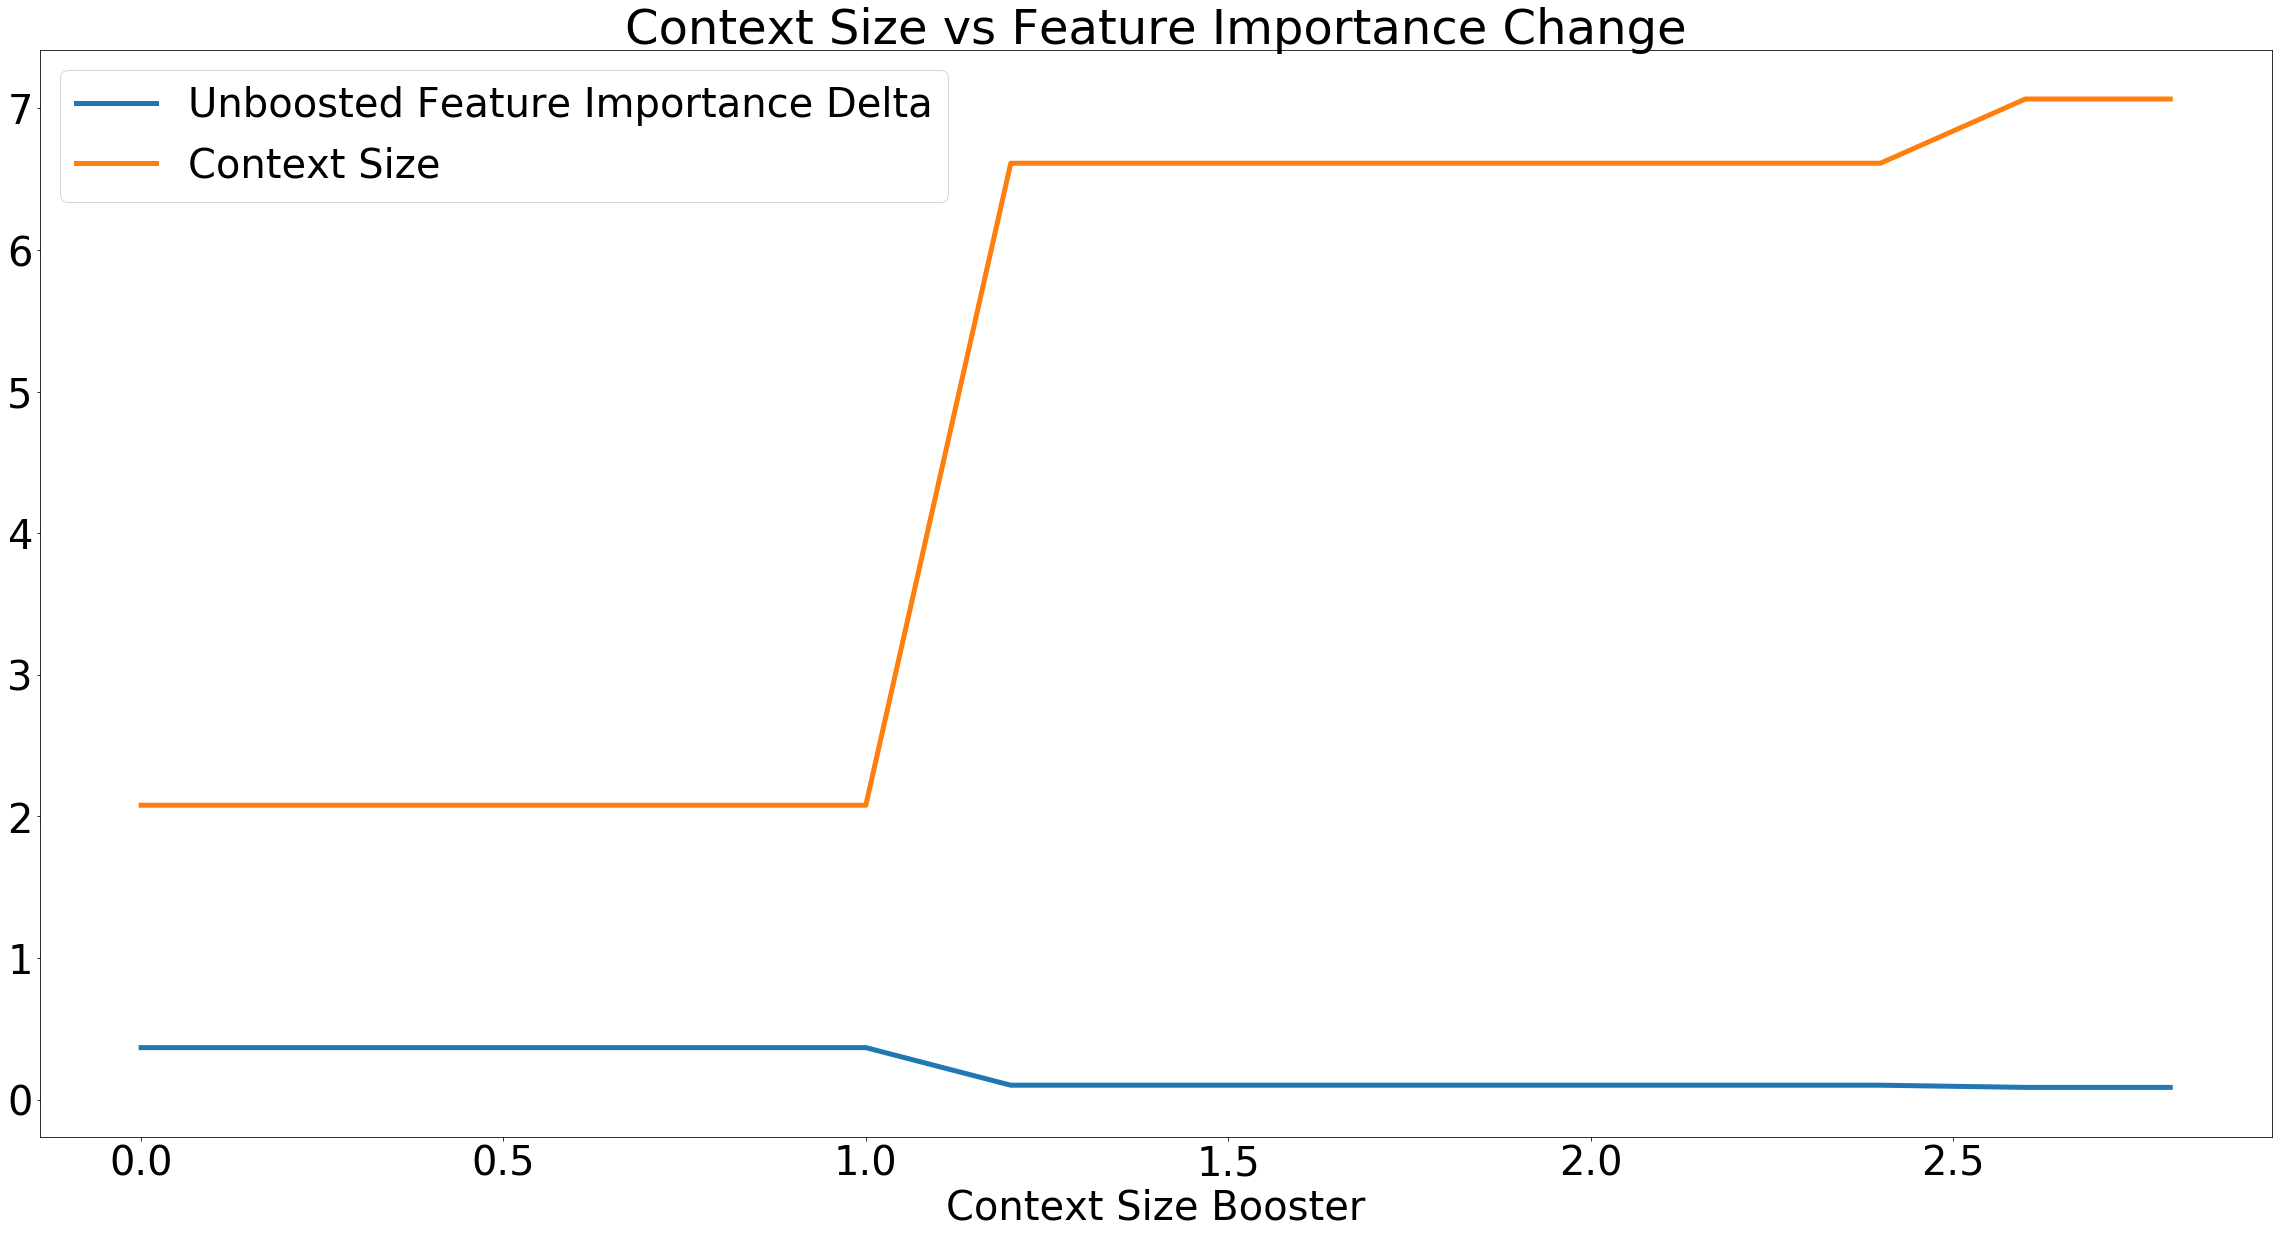

In [178]:
plt.figure(figsize=(40, 20))
plt.plot(test_ci_boosters, np.array(ci_deltas)/np.max(ci_deltas), label='Unboosted Feature Importance Delta')
plt.plot(test_ci_boosters, np.array(ci_sizes)/np.max(ci_sizes), label='Context Size')
plt.title('Context Size vs Feature Importance Change')
plt.xlabel('Context Size Booster')
plt.legend()
plt.show()

In [176]:
np.array(ci_sizes)

array([   8,    8,    8,    8,    8,    8,  744,  744,  744,  744,  744,
        744,  744, 1171, 1171])

Here we see the as we add the context size boost, the contexts do get bigger, but the true L1 difference between the parent and child feature importances decrease. This is with respect the the first feature split, which is supposed to be the one with the highest delta.

Since the contexts with the best CI delta can be arbitrarily small, we have to have large power penalties.

### Compare feature importances between global and contextual data - LR

In [124]:
tree.show()

Global
├── NumBank2NatlTradesWHighUtilization: (-9, -8), dist={0: 746, 1: 425}
│   ├── NumSatisfactoryTrades: (34, 50), dist={1: 3, 0: 2}
│   │   ├── NumTradesOpeninLast12M: (0, 4), dist={1: 2, 0: 2}
│   │   │   ├── ExternalRiskEstimate: (60, 79), dist={1: 2, 0: 1}
│   │   │   │   ├── NetFractionRevolvingBurden: (48, 95), dist={1: 1, 0: 1}
│   │   │   │   └── others, dist={1: 1}
│   │   │   └── others, dist={0: 1}
│   │   └── others, dist={1: 1}
│   └── others, dist={0: 744, 1: 422}
│       ├── NumInstallTradesWBalance: (1, 5), dist={0: 365, 1: 130}
│       │   ├── PercentTradesNeverDelq: (-9, 20), dist={0: 4, 1: 2}
│       │   │   ├── NumTrades60Ever2DerogPubRec: (0, 4), dist={0: 3, 1: 2}
│       │   │   └── others, dist={0: 1}
│       │   └── others, dist={0: 361, 1: 128}
│       │       ├── MSinceMostRecentInqexcl7days: (6, 11), dist={1: 11, 0: 11}
│       │       └── others, dist={0: 350, 1: 117}
│       └── others, dist={0: 379, 1: 292}
│           ├── MaxDelq2PublicRecLast12M: (0

In [141]:
show_feature_importance(lr, X, y, label='Full Dataset', show_plot=False)

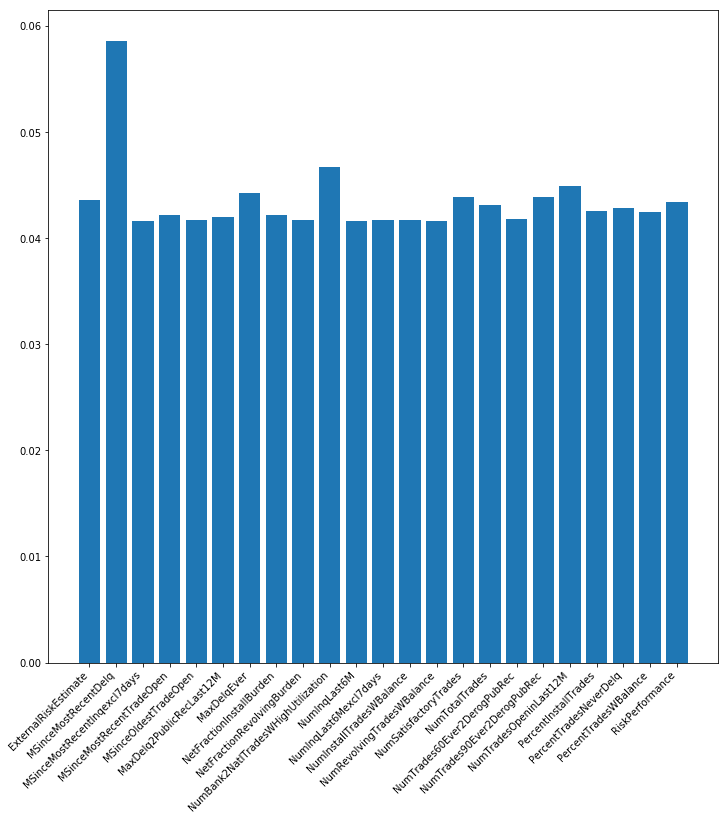

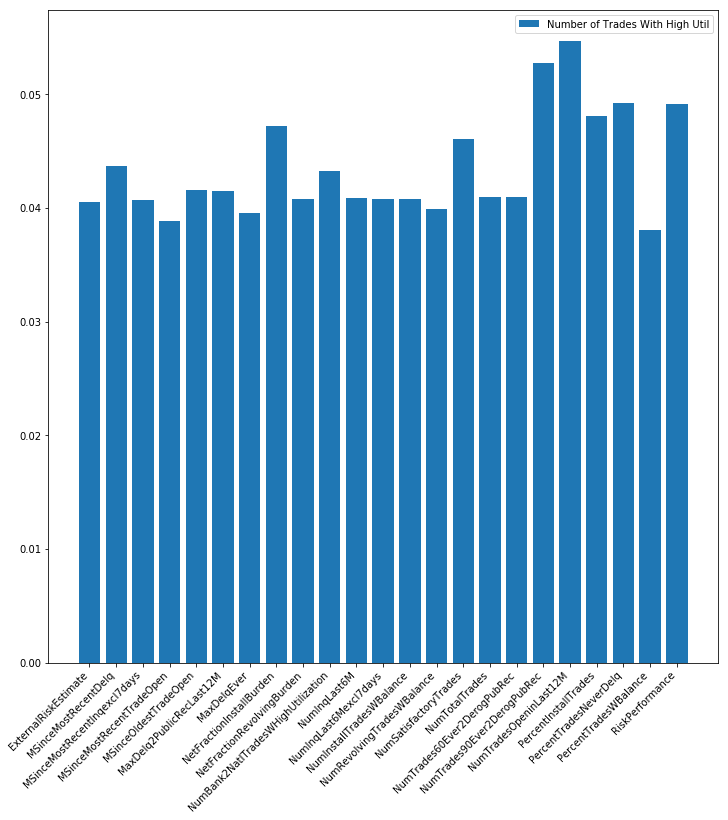

In [142]:
X_sub, y_sub = build_data_subset([(True, 'NumBank2NatlTradesWHighUtilization', (-9, -8))])
show_feature_importance(lr, X_sub, y_sub, label='Number of Trades With High Util', show_plot=False)
plt.legend()
plt.show()

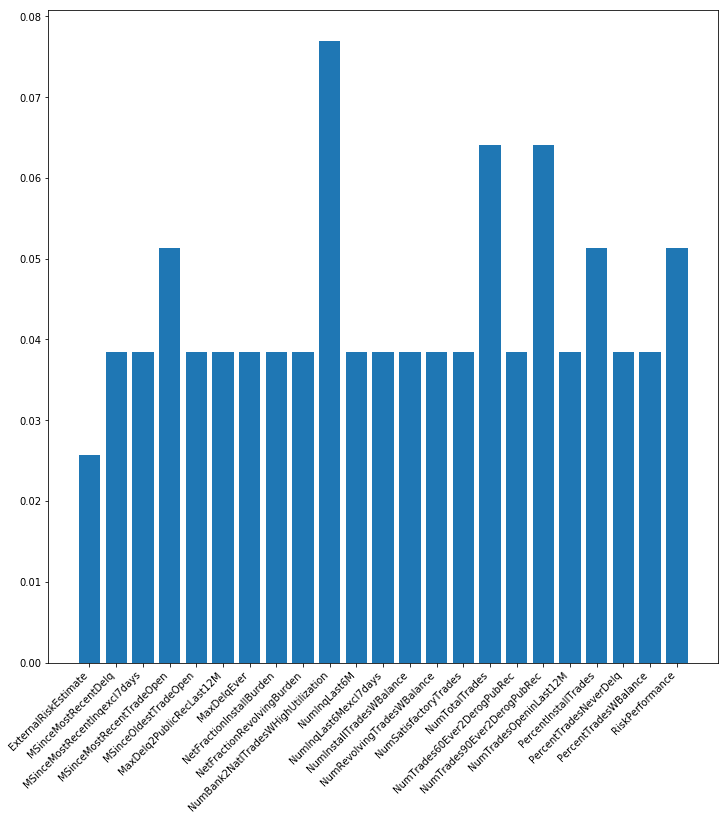

In [132]:
X_sub, y_sub = build_data_subset([(False, 'NumBank2NatlTradesWHighUtilization', (-9, -8)), (True, 'NumRevolvingTradesWBalance', (24, 29))])
show_feature_importance(lr, X_sub, y_sub)

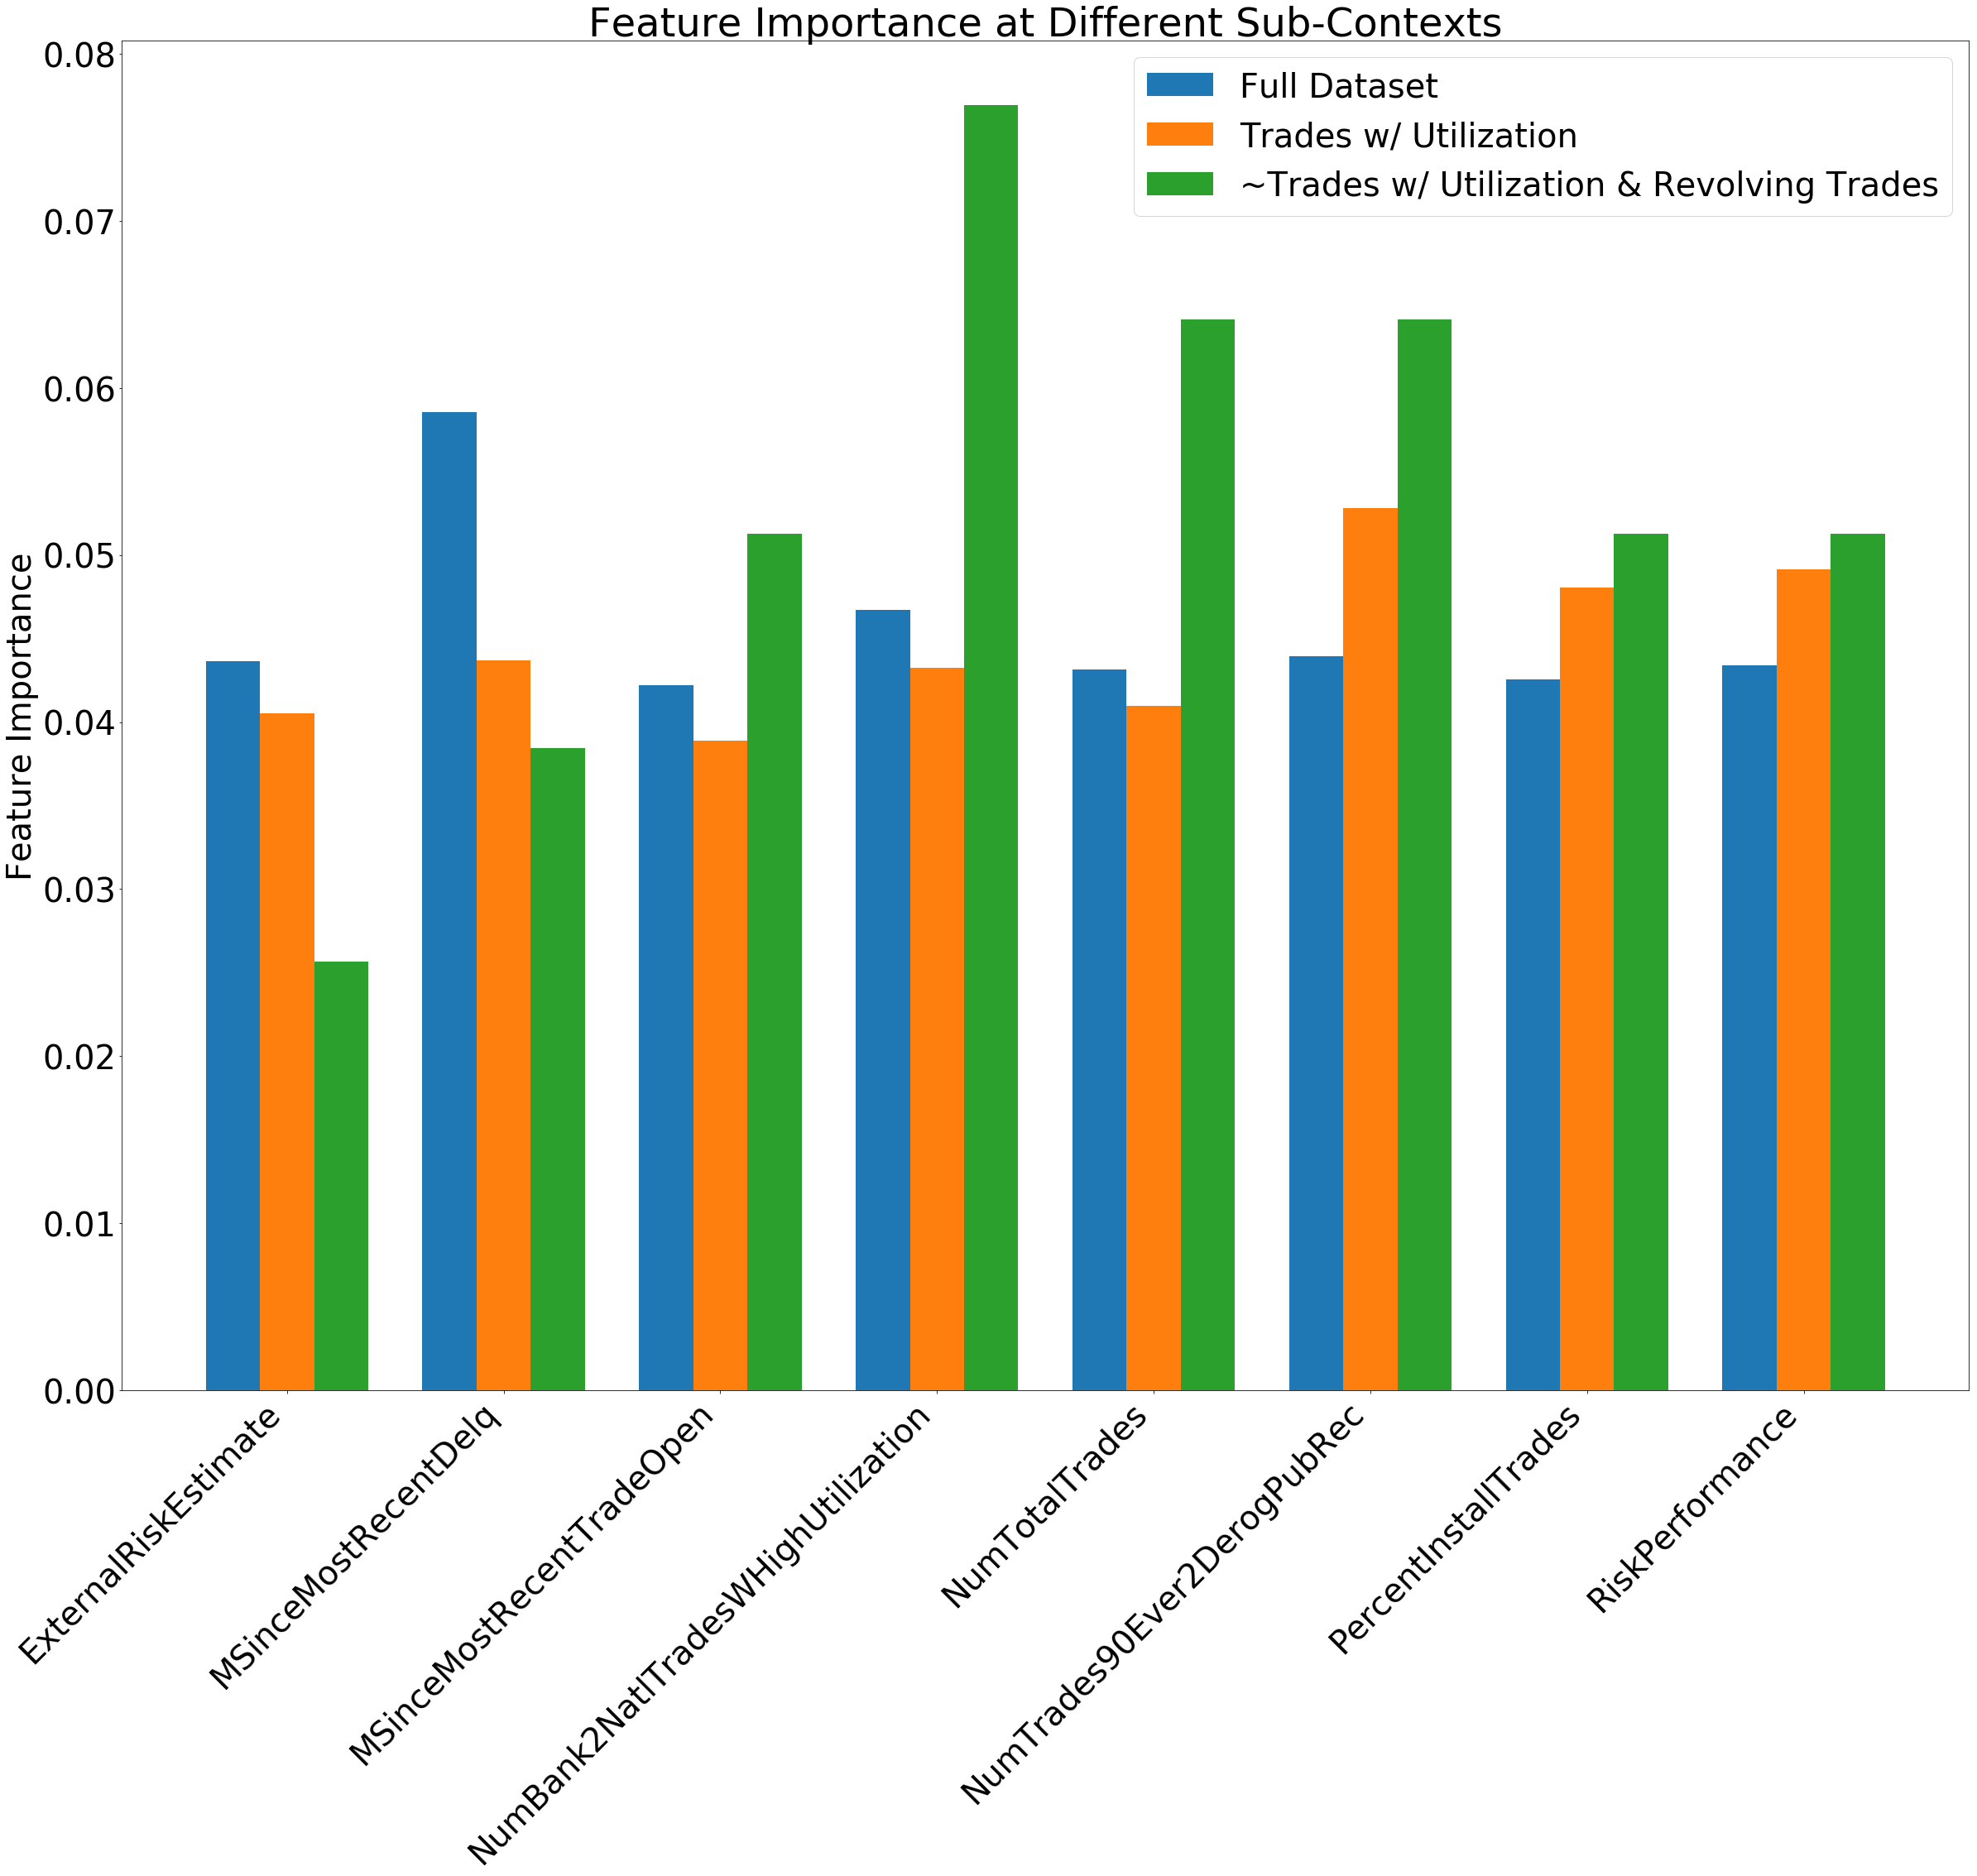

In [172]:
import numpy as np
import matplotlib.pyplot as plt


glob_fi = feature_importance(lr, X, y)
X_sub, y_sub = build_data_subset([(True, 'NumBank2NatlTradesWHighUtilization', (-9, -8))])
best_fi = feature_importance(lr, X_sub, y_sub)
X_sub, y_sub = build_data_subset([(False, 'NumBank2NatlTradesWHighUtilization', (-9, -8)), (True, 'NumRevolvingTradesWBalance', (24, 29))])
next_best_fi = feature_importance(lr, X_sub, y_sub)

sel_arr = np.array([0, 1, 3, 9, 15, 17, 19, 22])
col_names = bdf.columns[1:][sel_arr]

N = len(col_names)
fig, ax = plt.subplots(figsize=(40, 30))
ind = np.arange(N)    # the x locations for the groups
width = 0.25         # the width of the bars

glob = ax.bar(ind, glob_fi[sel_arr], width, label='Full Dataset')
best_split = ax.bar(ind + width, best_fi[sel_arr], width, label='Trades w/ Utilization')
next_best = ax.bar(ind + 2 * width, next_best_fi[sel_arr], width, label='~Trades w/ Utilization & Revolving Trades')

ax.set_title('Feature Importance at Different Sub-Contexts')
ax.set_xticks(ind + width)
ax.set_xticklabels(col_names, rotation = 45, ha="right")
ax.legend()
ax.set_ylabel('Feature Importance')

plt.show()

In [165]:
for i, col in enumerate(bdf.columns[1:]):
    print(col, i)

ExternalRiskEstimate 0
MSinceMostRecentDelq 1
MSinceMostRecentInqexcl7days 2
MSinceMostRecentTradeOpen 3
MSinceOldestTradeOpen 4
MaxDelq2PublicRecLast12M 5
MaxDelqEver 6
NetFractionInstallBurden 7
NetFractionRevolvingBurden 8
NumBank2NatlTradesWHighUtilization 9
NumInqLast6M 10
NumInqLast6Mexcl7days 11
NumInstallTradesWBalance 12
NumRevolvingTradesWBalance 13
NumSatisfactoryTrades 14
NumTotalTrades 15
NumTrades60Ever2DerogPubRec 16
NumTrades90Ever2DerogPubRec 17
NumTradesOpeninLast12M 18
PercentInstallTrades 19
PercentTradesNeverDelq 20
PercentTradesWBalance 21
RiskPerformance 22


In [32]:
import matplotlib.pyplot as plt

In [133]:
def show_feature_importance(model, X, y, label=None, show_plot=True):
#     svm = train_svm(X, y)
    fi = feature_importance(model, X, y)
    
    col_names = bdf.columns[1:]
    col_vals = range(len(col_names))
    plt.figure(figsize=(12, 12))
    plt.bar(col_vals, fi, label=label)
    plt.xticks(col_vals, col_names, rotation = 45, ha="right")
    if show_plot:
        plt.show()

use this to build the subset of the data from the tree view

In [69]:
col_bucket_range_map_rev = {keys: {bounds: val for val, bounds in d.items()} for keys, d in col_bucket_range_map.items()}

In [70]:
def build_data_subset(inclusions):
    X_sub = X.copy()
    y_sub = y.copy()
    
    for include_val, column, value_range in inclusions:
        col_idx = np.argwhere(bdf.columns == column)[0][0]
        col_value = col_bucket_range_map_rev[column][value_range]
        X_sub, y_sub = data_subsets(X_sub, y_sub, col_idx, col_value, eq_to_col_val=include_val)
    
    return X_sub, y_sub


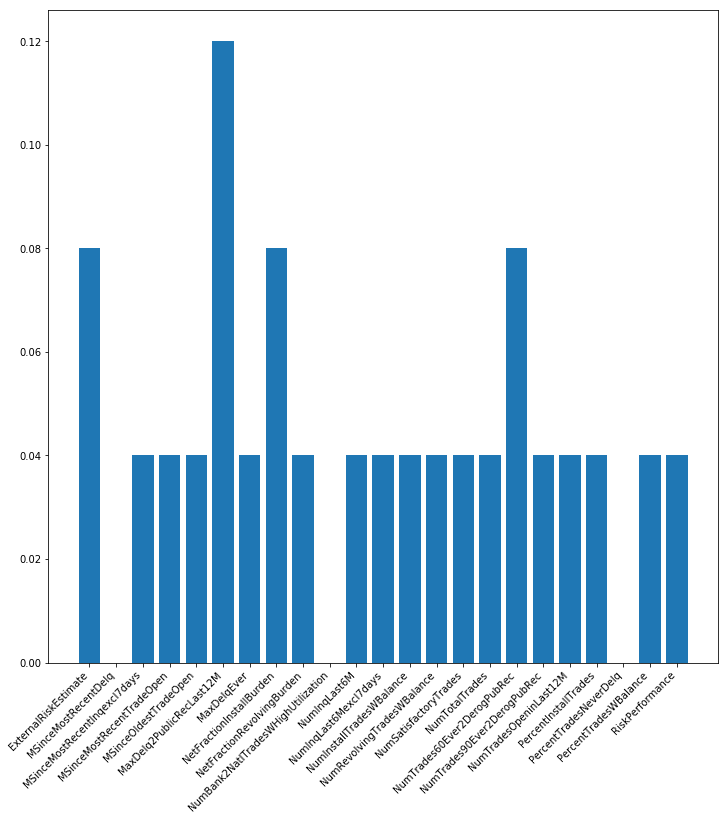

In [39]:
show_feature_importance(lr, *build_data_subset([(False, 'NetFractionInstallBurden', (-9, 95)), (True, 'PercentTradesNeverDelq', (63, 83))]))

### Compare feature importances between global and contextual data - SVM

In [52]:
tree.show()

Global
├── NumTrades60Ever2DerogPubRec: (0, 4), dist={0: 470, 1: 454}
│   ├── NumTotalTrades: (66, 87), dist={1: 4, 0: 4}
│   │   ├── MSinceOldestTradeOpen: (162, 323), dist={0: 3, 1: 2}
│   │   │   ├── MSinceMostRecentInqexcl7days: (-9, -7), dist={0: 2, 1: 1}
│   │   │   │   ├── NetFractionRevolvingBurden: (-9, 47), dist={1: 1, 0: 1}
│   │   │   │   └── others, dist={0: 1}
│   │   │   └── others, dist={1: 1, 0: 1}
│   │   └── others, dist={1: 2, 0: 1}
│   └── others, dist={0: 466, 1: 450}
│       ├── AverageMInFile: (156, 233), dist={0: 14, 1: 12}
│       │   ├── PercentTradesWBalance: (42, 62), dist={1: 6, 0: 3}
│       │   │   ├── NetFractionRevolvingBurden: (-9, 47), dist={1: 6, 0: 2}
│       │   │   └── others, dist={0: 1}
│       │   └── others, dist={0: 11, 1: 6}
│       │       ├── MSinceMostRecentInqexcl7days: (-9, -7), dist={1: 4, 0: 4}
│       │       └── others, dist={0: 7, 1: 2}
│       └── others, dist={0: 452, 1: 438}
│           ├── MSinceMostRecentInqexcl7days: (12, 17

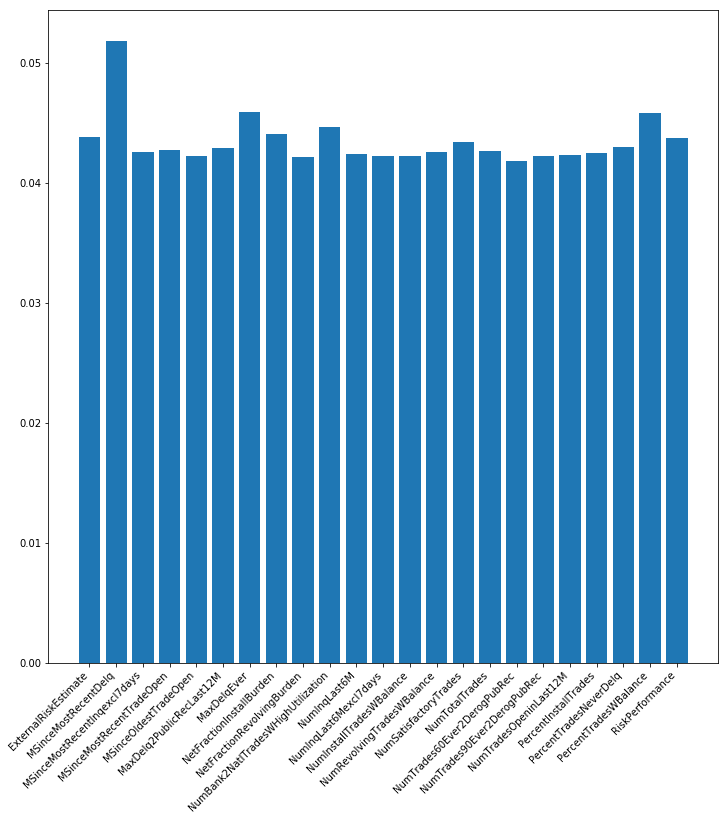

In [59]:
show_feature_importance(X[:1000], y[:1000])

Number Trades 60+ Ever, lower is better

In [65]:
col_bucket_range_map['NumTrades60Ever2DerogPubRec']

{-0.33333333333333331: (-9, -9),
 0.0: (0, 4),
 0.33333333333333331: (5, 9),
 0.66666666666666663: (10, 14),
 1.0: (16, 19)}

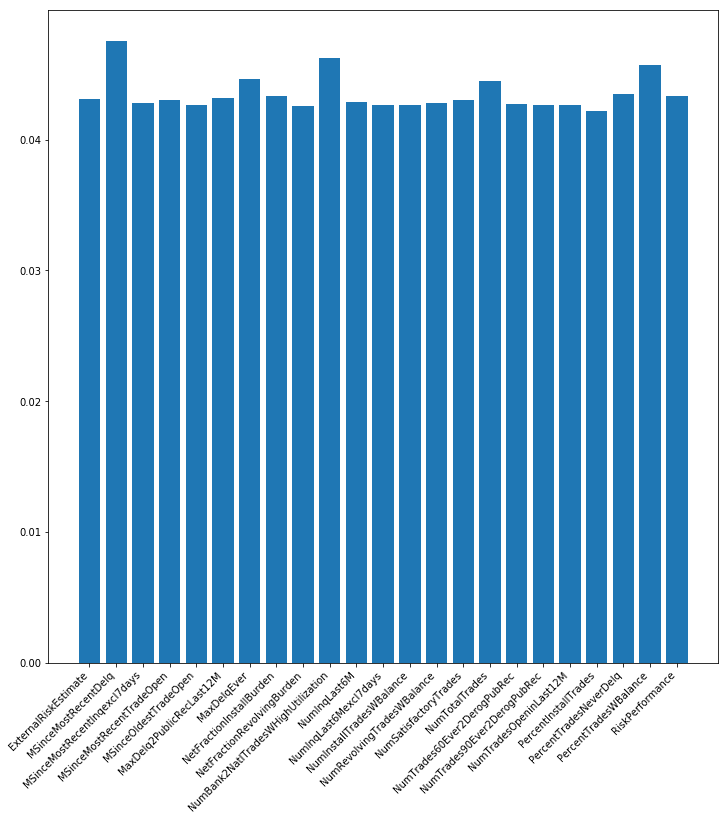

In [60]:
show_feature_importance(*build_data_subset([(True, 'NumTrades60Ever2DerogPubRec', (0, 4))]))

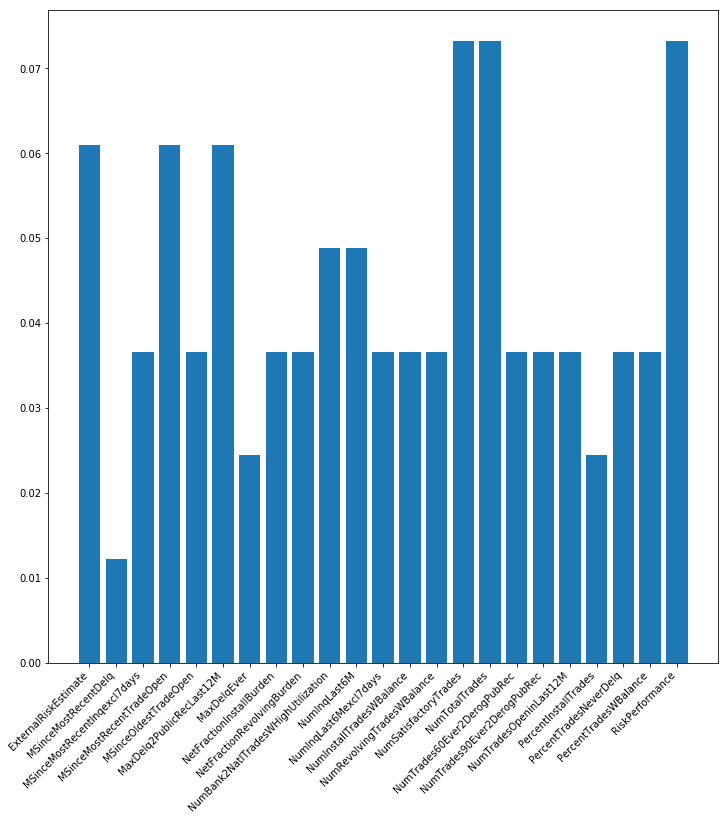

In [63]:
show_feature_importance(*build_data_subset([(True, 'NumTrades60Ever2DerogPubRec', (0, 4)), (True, 'NumTotalTrades', (66, 87))]))

Net Fraction Revolving Burden. This is revolving balance divided by credit limit

In [66]:
col_bucket_range_map['NetFractionRevolvingBurden']

{0.0: (-9, 47),
 0.25: (48, 95),
 0.5: (96, 135),
 0.75: (154, 165),
 1.0: (232, 232)}

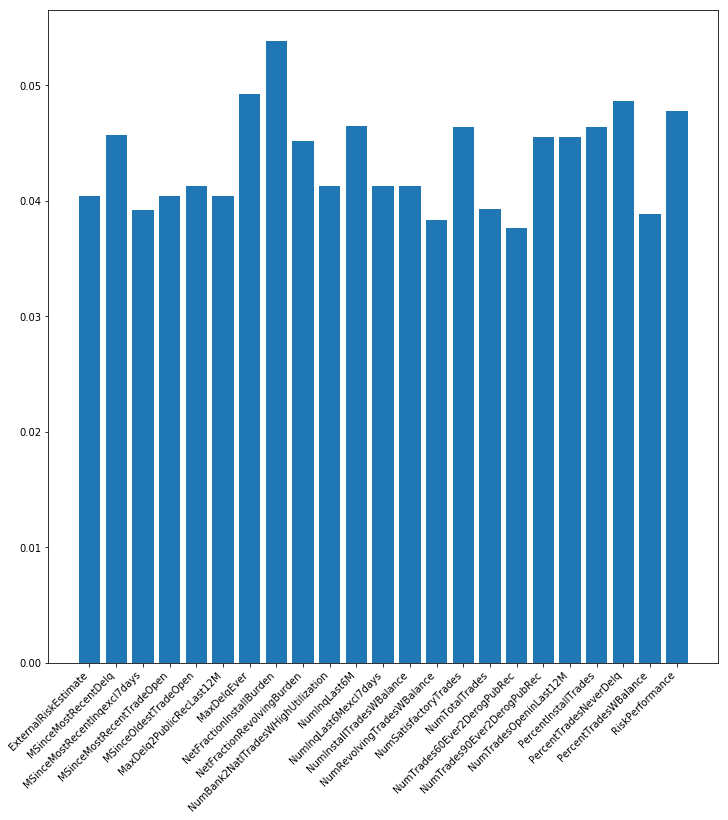

In [64]:
show_feature_importance(*build_data_subset([(False, 'NumTrades60Ever2DerogPubRec', (0, 4)), (True, 'NetFractionRevolvingBurden', (-9, 47))]))

### Compare feature importances between global and contextual data

In [72]:
tree.show()

Global
├── MaxDelqEver: (6, 8), dist={1: 3958, 0: 3574}
│   ├── PercentTradesNeverDelq: (-9, 20), dist={0: 3, 1: 1}
│   └── others, dist={1: 3957, 0: 3571}
│       ├── NumTrades60Ever2DerogPubRec: (10, 14), dist={1: 1, 0: 1}
│       └── others, dist={1: 3956, 0: 3570}
│           ├── AverageMInFile: (322, 383), dist={1: 1, 0: 1}
│           └── others, dist={1: 3955, 0: 3569}
│               ├── NumInstallTradesWBalance: (12, 16), dist={1: 11, 0: 4}
│               └── others, dist={1: 3944, 0: 3565}
└── others, dist={0: 1885, 1: 1042}
    ├── NumRevolvingTradesWBalance: (16, 23), dist={0: 7, 1: 3}
    │   ├── MSinceOldestTradeOpen: (-9, 161), dist={0: 2, 1: 1}
    │   └── others, dist={0: 5, 1: 2}
    │       ├── AverageMInFile: (-9, 77), dist={1: 1, 0: 1}
    │       └── others, dist={0: 4, 1: 1}
    │           ├── MSinceMostRecentDelq: (-9, 17), dist={0: 4, 1: 1}
    │           └── others, dist={}
    └── others, dist={0: 1878, 1: 1039}
        ├── MSinceMostRecentTradeOpen: (79, 

Global

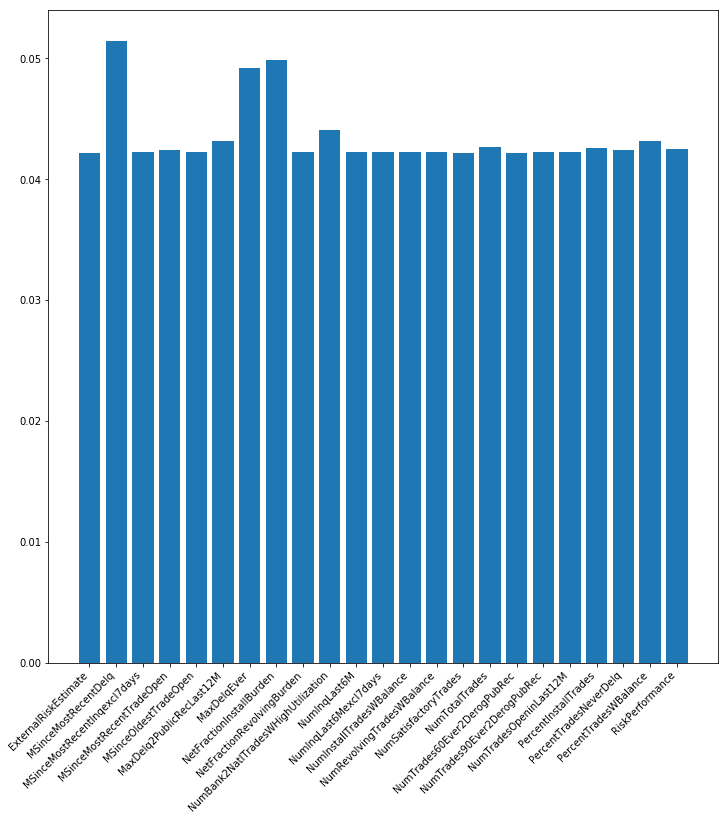

In [78]:
show_feature_importance(X, y)

For the context where MaxDelqEver $\in$ [6, 8], here is the contextual model interpretation. We see that from the global context, the importance for the feature `MSinceMostRecentDelq` varies, Months since the most recently delinquency. This makes sense, if you have historically beeen charged with a crime, it is on permanent record and affects financial well being.

In [82]:
X_sub, y_sub = build_data_subset([(True, 'MaxDelqEver', (6, 8))])

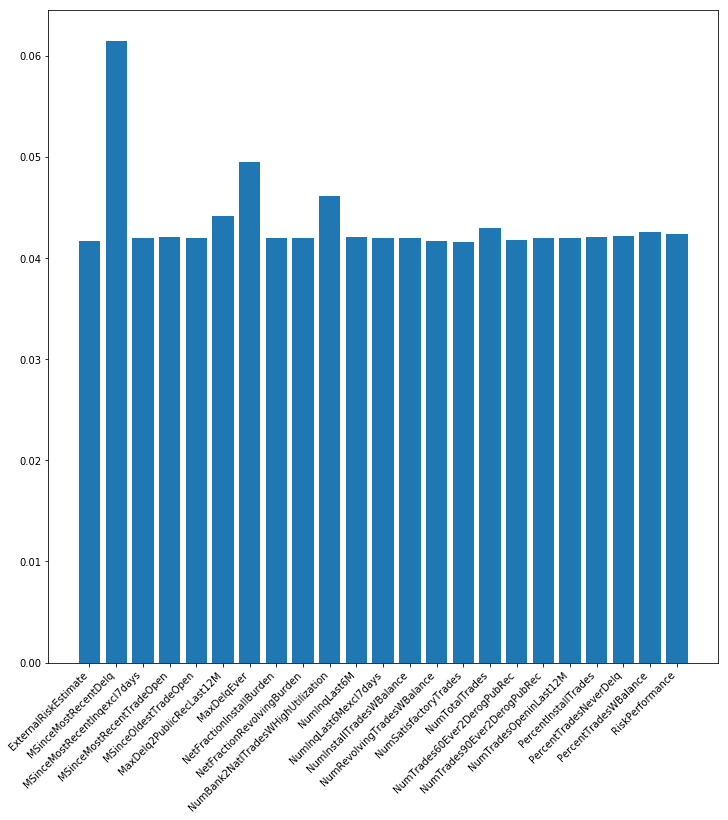

In [83]:
show_feature_importance(X_sub, y_sub)

Those who have records of delinquency and have a certain number of trades
Net Fraction Installment Burden. This is installment balance divided by original loan amount (higher is worse)

In [95]:
col_bucket_range_map['NetFractionInstallBurden']

{0.0: (-9, 95), 0.25: (96, 190), 0.5: (196, 196), 1.0: (471, 471)}

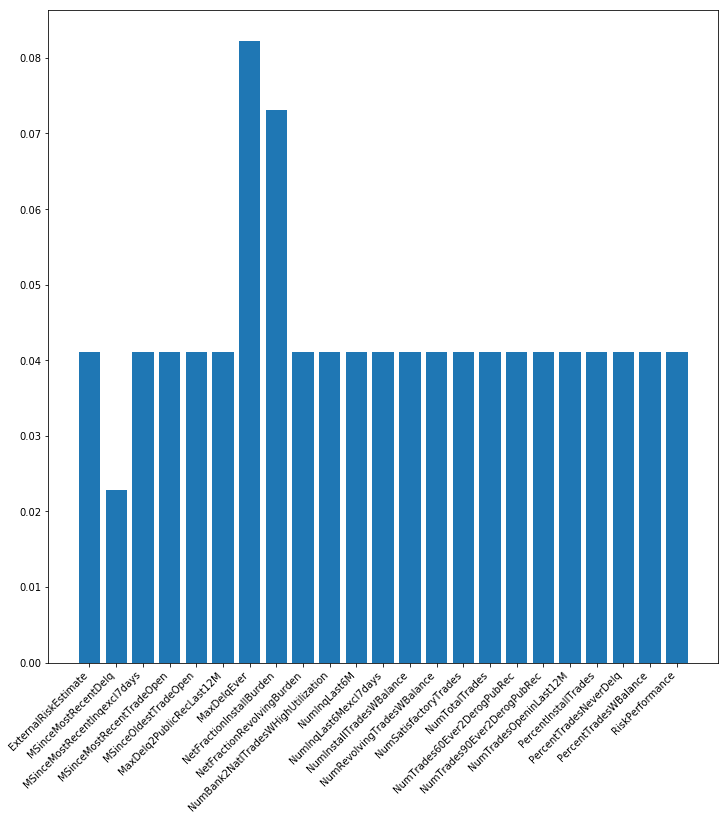

In [86]:
show_feature_importance(*build_data_subset([(False, 'MaxDelqEver', (6, 8)), (True, 'NumRevolvingTradesWBalance', (16, 23))]))

Number Revolving Trades with Balance

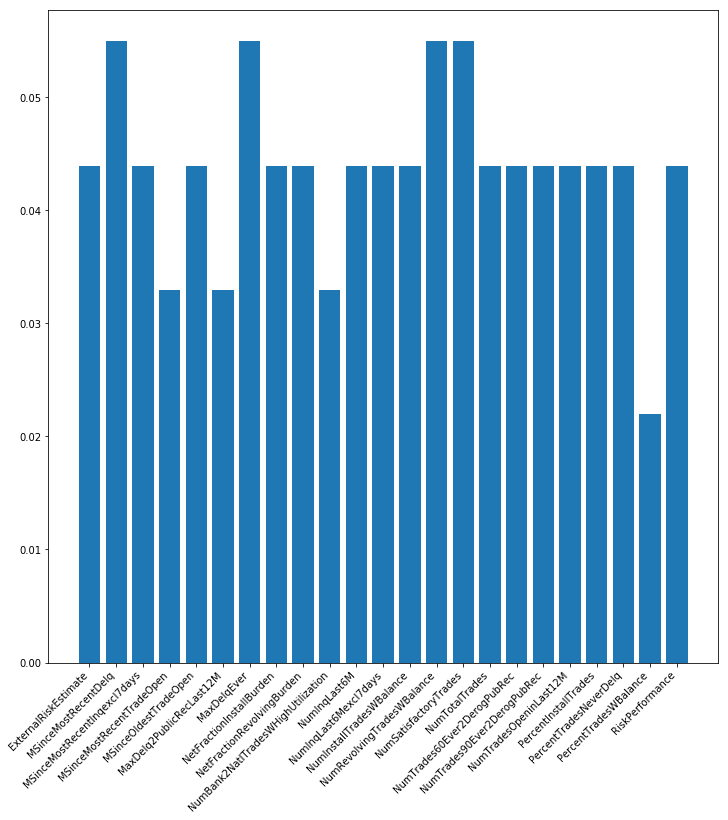

In [96]:
show_feature_importance(*build_data_subset([(False, 'MaxDelqEver', (6, 8)), (False, 'NumRevolvingTradesWBalance', (16, 23)), (True, 'MSinceMostRecentTradeOpen', (79, 152))]))

### Using a decomposable feature importance metric like SHAP

In [472]:
import importlib

In [475]:
importlib.reload(tqdm)

<module 'tqdm' from '/Users/karansamel/Library/Python/3.6/lib/python/site-packages/tqdm/__init__.py'>

In [476]:
import shap

In [469]:
svc_linear = SVC(kernel='rbf', probability=True)
svc_linear.fit(X[:100], y[:100])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [477]:
explainer = shap.KernelExplainer(svc_linear.predict_proba, X[:100])

In [478]:
shap_values = explainer.shap_values(X[:100])

Widget Javascript not detected.  It may not be installed or enabled properly.


/Users/karansamel/Library/Python/3.6/lib/python/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [ ]:


# explain all the predictions in the test set
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [493]:
global_fi = np.mean(np.abs(shap_values[0]), axis=0)

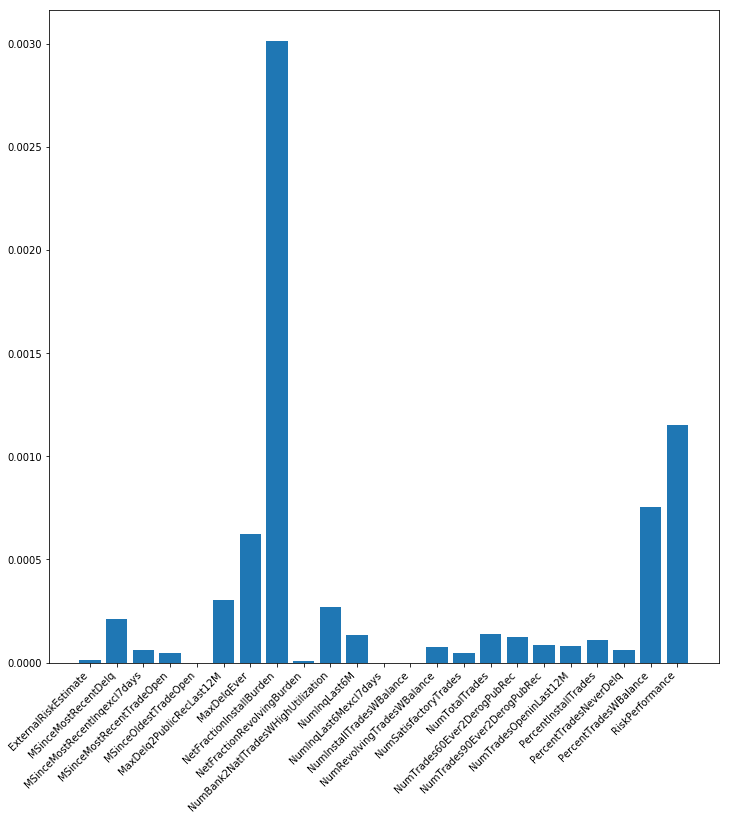

In [494]:
col_names = bdf.columns[1:]
col_vals = range(len(col_names))
plt.figure(figsize=(12, 12))
plt.bar(col_vals, global_fi)
plt.xticks(col_vals, col_names, rotation = 45, ha="right")
plt.show()

In [481]:
shap.initjs()

In [482]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X[:100])